In [1]:
import random
import torch

words = open('names.txt', 'r').read().splitlines()
words = sorted(list(set(words))) # set cause uncontrollable randomness， sorted for reproducibility
random.seed(42)
random.shuffle(words)

chs = list(set(''.join(words + ['.'])))
chs = sorted(chs, reverse=False)
stoi = {ch: i for i, ch in enumerate(chs)}
itos = {i: ch for i, ch in enumerate(chs)}

# predict next token use previous tokens
block_size = 10
X, Y = [], []

for w in words:
    context = '.' * block_size
    for ch in w + '.':
        x = [stoi[c] for c in context]
        y = stoi[ch]
        X.append(x)
        Y.append(y)
        context = context[1:] + ch

X = torch.tensor(X)
Y = torch.tensor(Y)
n1, n2  = int(0.8 * len(X)), int(0.9 * len(X))

X_train, X_val, X_test = X.tensor_split([n1, n2])
Y_train, Y_val, Y_test = Y.tensor_split([n1, n2])

X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape


(torch.Size([169062, 10]),
 torch.Size([21133, 10]),
 torch.Size([21133, 10]),
 torch.Size([169062]),
 torch.Size([21133]),
 torch.Size([21133]))

# use manual backprop

In [3]:
from tiny_torch import *

n_embd = 10
n_hidden = 60
vocab_size = 27
dtype = torch.float64

# model
torch.manual_seed(42)
layers = [
    Embedding(vocab_size, n_embd, dtype=dtype), Flatten(), 
    Linear(n_embd * block_size, n_hidden, bias=False, dtype=dtype), 
    BatchNorm1d(n_hidden, dtype=dtype), 
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False, dtype=dtype), 
    BatchNorm1d(n_hidden, dtype=dtype), 
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False, dtype=dtype), 
    BatchNorm1d(n_hidden, dtype=dtype), 
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False, dtype=dtype), 
    BatchNorm1d(n_hidden, dtype=dtype), 
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False, dtype=dtype), 
    BatchNorm1d(n_hidden, dtype=dtype), 
    Tanh(),
    Linear(n_hidden, vocab_size, bias=False, dtype=dtype),
    BatchNorm1d(vocab_size, dtype=dtype), 
]
layers[-1].weight.data *= 0.1
# layers[-1].bias.data = torch.randn_like(layers[-1].bias) * 0.01
# for i, layer in enumerate(layers[:-1]):
#     if isinstance(layer, Tanh):
#         layers[i+1].weight.data *= 5 / 3

# loss
loss_fn = CrossEntropyLoss()

params = [p for layer in layers for p in layer.parameters()]
print(f'num of params: {sum(p.numel() for p in params)}')

num of params: 22944


In [4]:
import math

# log
ud = {i: [] for i in range(len(params))}
layer_o = {i: [] for i in range(len(layers))}
layer_g = {i: [] for i in range(len(layers))}

# lre = torch.linspace(-3, 0, breaks+1)
# lri = 10 ** lre # for lr search
lossi = []
val_lossi = []
eval_interval = 10000
bs = 32
n_steps = 20000
ini_lr = 0.1
torch.manual_seed(42)
for step in range(n_steps):
    # lr = lri[step]
    lr = 0.9 * ini_lr * 0.5 * (1 + math.cos(math.pi * step / n_steps)) + 0.1 * ini_lr
    # lr = ini_lr * (1 - 0.9 * (step / n_steps))
    idx = torch.randint(0, X_train.shape[0], (bs,))
    x, y = X_train[idx], Y_train[idx]

    # forward and store output of each layer L[i]
    o = x
    for i, layer in enumerate(layers):
        o = layer(o)
        layer_o[i].append(o)
    logits = o
    loss = loss_fn(logits, y)
    lossi.append(loss.log10().item())

    # backward and store grad of each layer dL[i]
    do = loss_fn.backward(grad=1.0)
    for i in range(len(layers)-1, -1, -1):
        layer_g[i].append(do)
        do = layers[i].backward(do)
    
    # update
    grads = [g for layer in layers for g in layer.grads()]
    for i, (p, g) in enumerate(zip(params, grads)):
        ud[i].append(((lr * g).std() / p.data.std()).log10().item())
        p.data -= lr * g
        g.zero_()
    
    # eval
    if ((step + 1) % 1000  == 0) or step == 0:
        for layer in layers:
            layer._training = False
        x, y = X_val, Y_val
        o = x
        for i, layer in enumerate(layers):
            o = layer(o)
        logits = o
        val_loss = loss_fn(logits, y)
        val_lossi.append(val_loss.log10().item())
        print(f'step: {step}, train loss: {loss.item()}, val loss: {val_loss.item()}')
        for layer in layers:
            layer._training = True


for i, layer in enumerate(layers):
    layer.outs = layer_o[i]
    layer.gds = layer_g[i]

step: 0, train loss: 3.3070838418208854, val loss: 3.2941046250478103
step: 999, train loss: 2.320498499019706, val loss: 2.4244017820816595
step: 1999, train loss: 2.2750430969522584, val loss: 2.3280812680813905
step: 2999, train loss: 2.4458958160525457, val loss: 2.289569226306636
step: 3999, train loss: 2.0846240023173235, val loss: 2.2422597598620606
step: 4999, train loss: 1.9295871818248544, val loss: 2.228998326484083
step: 5999, train loss: 2.175815360807591, val loss: 2.211783995394269
step: 6999, train loss: 2.0487054918940406, val loss: 2.205621973605829
step: 7999, train loss: 2.3027622459312824, val loss: 2.1887501497091555
step: 8999, train loss: 2.224023683142402, val loss: 2.173215704023192
step: 9999, train loss: 2.446079178764448, val loss: 2.171530926323562
step: 10999, train loss: 2.135863136551283, val loss: 2.1616871936866953
step: 11999, train loss: 2.078033959804888, val loss: 2.1517234688238007
step: 12999, train loss: 1.8811494116935177, val loss: 2.14750465

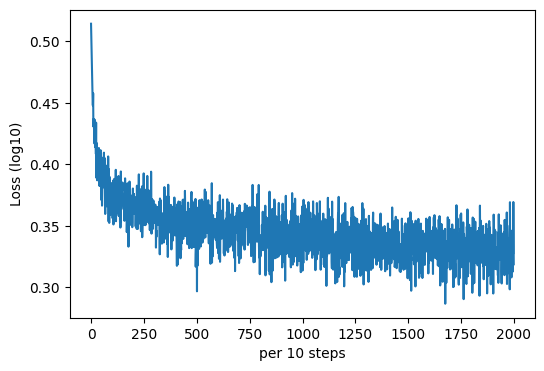

In [5]:
import matplotlib.pyplot as plt


# plt.figure(figsize=(6, 4))
# plt.xlabel('Step')
# plt.ylabel('Loss (log10)')
# plt.title('lr search')
# plt.plot(lre, lossi)

window = 10
avg_lossi = [torch.mean(torch.tensor(lossi[i:i+window])) for i in range(0, len(lossi), window)]
plt.figure(figsize=(6, 4))
plt.xlabel(f'per {window} steps')
plt.ylabel('Loss (log10)')
plt.plot(avg_lossi)

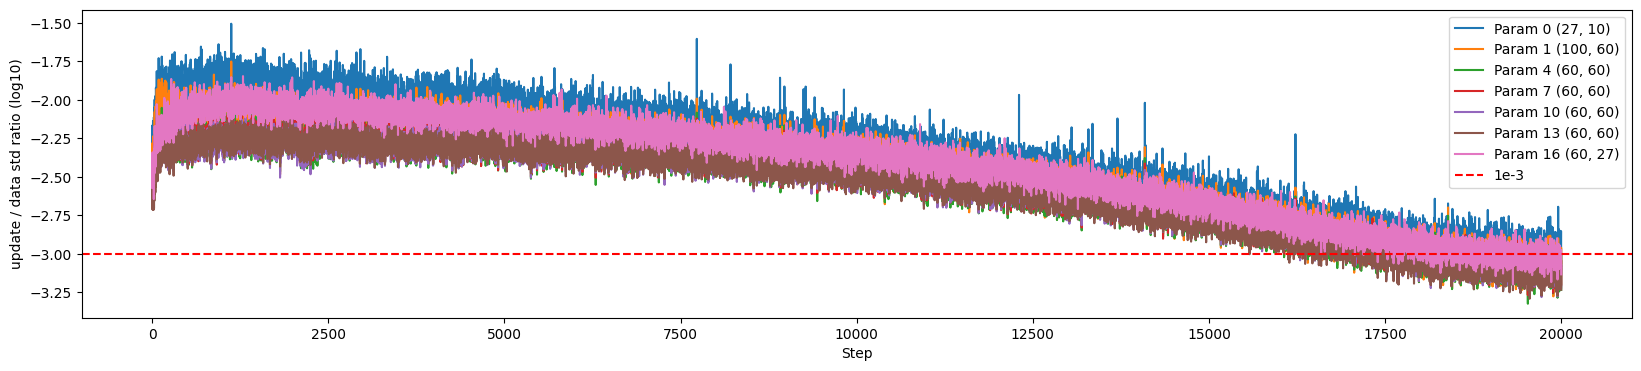

In [6]:
params_sub = []
idx = 0
for layer in layers:
    for p in layer.parameters():
        if isinstance(layer, (Linear, Embedding)):
            params_sub.append(idx)
        idx += 1

plt.figure(figsize=(20, 4))
for idx in params_sub:
    plt.plot(range(len(ud[idx])), ud[idx], label=f'Param {idx} {tuple(params[idx].shape)}')
plt.axhline(-3, color='red', linestyle='--', label='1e-3')
plt.xlabel('Step')
plt.ylabel('update / data std ratio (log10)')
plt.legend()
plt.show()


## interactive plot

In [10]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def plot_histograms(step):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8))
    
    # 绘制输出直方图
    for i, layer in enumerate(layers):
        if isinstance(layer, Tanh):
            hist, bins = torch.histogram(layer.outs[step], bins=100)
            ax1.plot(bins[:-1], hist.detach().numpy(), label=f'Layer {i} {layer.__class__.__name__}')
    
    ax1.set_title(f'Histogram of Layer Outputs in step {step}')
    ax1.set_xlim(-1.1, 1.1)
    ax1.legend()
    
    # 绘制梯度直方图
    for i, layer in enumerate(layers):
        if isinstance(layer, Tanh):
            hist, bins = torch.histogram(layer.gds[step], bins=100)
            ax2.plot(bins[:-1], hist.detach().numpy(), label=f'Layer {i} {layer.__class__.__name__}')
    
    ax2.set_title(f'Histogram of Layer Gradients in step {step}')
    ax2.set_xlim(-0.025, 0.025)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# interactive plot
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=n_steps,
    step=(n_steps//30),
    description='Step:',
    continuous_update=False  # immediate update when dragging, set to False to reduce computation
)

# 创建交互式部件
interactive_plot = widgets.interactive(plot_histograms, step=slider)
display(interactive_plot)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Step:', max=20000, step=666), O…